# Project 2: Initial Analysis of movie Dataset

## 1.Installs 

In [76]:
!pip install Wikidata
!pip install NetworkX

## 2.Import

In [77]:
from datetime import datetime, date, time
import os 
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import json
import requests
from scipy import stats
from matplotlib import pyplot as plt
from wikidata.client import Client
import networkx as nx

## 3.Constants

In [3]:
# query to take informations from wikidata
WIKIDATA_QUERY = """
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P646 ?statement0.
      ?statement0 (ps:P646) "%s".
    }
    LIMIT 100
  }
}

"""

In [4]:
Name_movie = ['Wikipedia movie ID',
              'Freebase movie ID',
              'Movie name',
              'Movie release date',
              'Movie box office revenue',
              'Movie runtime',
              'Movie languages',
              'Movie countries',
              'Movie genres']

Name_character = ['Wikipedia Movie ID',
                  'Freebase Movie ID',
                  'Movie release date',
                  'Character Name',
                  'Actor DOB',
                  'Actor gender',
                  'Actor height',
                  'Actor ethnicity',
                  'Actor Name',
                  'Actor age at movie release',
                  'unknown 1',
                  'unknown 2',
                  'Freebase character map']

## 4.Import files

In [5]:
#extract tar data
DATA_FOLDER = './data/'
DATA_PATH_TAR = os.path.join(DATA_FOLDER, 'MovieSummaries.tar.gz')


In [6]:
# open file
file = tarfile.open(DATA_PATH_TAR)
  
# extract files
file.extractall('./data')

# close file
file.close()

In [7]:
#read different datas as dataframes
DATA_FOLDER_TAR = './data/MovieSummaries'

DATA_PATH_MOVIE = os.path.join(DATA_FOLDER_TAR,'movie.metadata.tsv')

DATA_PATH_RATINGS = os.path.join(DATA_FOLDER,'title.ratings.tsv.gz')

DATA_PATH_NAME = os.path.join(DATA_FOLDER, 'title.basics.tsv.gz')

df_movie = pd.read_csv(DATA_PATH_MOVIE, sep ='\t', header = None, names = Name_movie, na_values = ['{}', ' '], lineterminator='\n')

df_movies_kaggle = pd.read_csv(DATA_FOLDER + 'movies_metadata.csv')

df_movies_IMDb_ratings = pd.read_csv(DATA_PATH_RATINGS, sep ='\t', na_values = ['{}', ' '], lineterminator='\n')

df_movies_IMDb_name = pd.read_csv(DATA_PATH_NAME, sep ='\t', na_values = ['{}', ' '], lineterminator='\n')

C:\Users\Matthias Forestier\AppData\Local\Temp\ipykernel_15624\3951101361.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies_kaggle = pd.read_csv(DATA_FOLDER + 'movies_metadata.csv')
C:\Users\Matthias Forestier\AppData\Local\Temp\ipykernel_15624\3951101361.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies_IMDb_name = pd.read_csv(DATA_PATH_NAME, sep ='\t', na_values = ['{}', ' '], lineterminator='\n')


In [8]:
#character Metadata
DATA_PATH_CHAR = os.path.join(DATA_FOLDER_TAR,'character.metadata.tsv')

df_character = pd.read_csv(DATA_PATH_CHAR, sep ='\t', header = None, names = Name_character, na_values = ' ', lineterminator='\n')

## 5.First Analysis ##
On the primary test we wanted to see how many actors were linked to a movie. We discovered that all actors that played characters in the character database have a movie from the movie database linked to their character.

In [9]:
#how many characters we have 
df_character.shape

(450669, 13)

In [10]:
df_character = df_character.rename(columns={"Wikipedia Movie ID": "Wikipedia movie ID"})

In [11]:
df_character_movie = df_movie.merge(df_character, how ='inner', on=['Wikipedia movie ID'])
df_character_movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Freebase Movie ID,...,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,unknown 1,unknown 2,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,12476867,/m/02w7zz8,Spliced,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",/m/02w7zz8,...,NaN,NaN,NaN,NaN,NaN,Billy Morton,NaN,/m/0gchkcy,NaN,/m/0gc4lfm
450665,12476867,/m/02w7zz8,Spliced,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",/m/02w7zz8,...,NaN,1982-01-28,NaN,NaN,NaN,Andrea Runge,19.0,/m/0gckh4f,NaN,/m/0gbx_rk
450666,12476867,/m/02w7zz8,Spliced,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",/m/02w7zz8,...,NaN,NaN,F,NaN,NaN,Wendy Anderson,NaN,/m/0gcp8fv,NaN,/m/0gby01h
450667,12476867,/m/02w7zz8,Spliced,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",/m/02w7zz8,...,NaN,NaN,NaN,NaN,NaN,Ariel Bastian,NaN,/m/0gdkb51,NaN,/m/0gdkb55


As the size of the merged dataframe, df_character_movie, is the same as the one of df_character, it means that all actors are linked to a movie.
We can see that we have two unknown columns. The freebase ID was not found in Wikidata, it doesn't exist. So we decide to remove those two columns. 

In [12]:
df_character = df_character.drop(["unknown 1", "unknown 2"], 1)

C:\Users\Matthias Forestier\AppData\Local\Temp\ipykernel_15624\1467689330.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_character = df_character.drop(["unknown 1", "unknown 2"], 1)


#### 5.1 Creating and arranging the orignal datasets ####
We realised during our first study of the dataframes from the two original datasets that some informations were encoded (ethnicity). Moreover, some of the data wasn't expressed in the same format (the movie release date). Finally, some informations were difficult to call (because of an additional ID code in front of their names): for example the movie genres, countries or languages. We decided to do some cleaning and simplifications on the data.

In [13]:
def filtering_function(column):
    """filtering function that allows to get strings without their freebase ID number
    
    Args:
        column : column of the dataframe we need to filter
    
    Returns :
        _filtered : the filtered column
        
    """
    _filtered = []
    i = 0
    for s in column:
        S_r = ''
        c = 1
        if (isinstance(s, str)):
            if s.find(',') == -1:
                S_r = s[(s.find(':')+3):(s.find(':}')-1)]
            else:
                a = s
                S_r = a[(a.find(':')+3):(a.find(',')-1)]
                a = a[(a.find(',')+1):]
                while c>0:
                    if a.find(',') == -1:
                        S_r =  S_r + ', ' + a[(a.find(':')+3):(a.find(':}')-1)]
                        c = 0
                    else:
                        S_r = S_r + ', ' + a[(a.find(':')+3):(a.find(',')-1)]
                        a = a[(a.find(',')+1):]
        else:
            S_r = 'None' 
        _filtered.append(S_r)
    return _filtered


In [14]:
#Language Filtering
language_filtered = filtering_function(df_movie['Movie languages'])
df_movie['Movie languages filtered'] = language_filtered

#Countries Filtering
countries_filtered = filtering_function(df_movie['Movie countries'])
df_movie['Movie countries filtered'] = countries_filtered

#Genres Filtering
genres_filtered = filtering_function(df_movie['Movie genres'])
df_movie['Movie genres filtered'] = genres_filtered

In [15]:
df_movie[['Wikipedia movie ID', 'Movie languages filtered', 'Movie genres filtered', 'Movie countries filtered']].head(3)

,Wikipedia movie ID,Movie languages filtered,Movie genres filtered,Movie countries filtered
0,975900,English Language,"Thriller, Science Fiction, Horror, Adventure, ...",United States of America
1,3196793,English Language,"Mystery, Biographical film, Drama, Crime Drama",United States of America
2,28463795,Norwegian Language,"Crime Fiction, Drama",Norway


In [22]:
def date(df_date):
    """unify the dates of a dataframe to year only 
    
    Args:
        df_date: the column of the dataframe containing dates
        
    Returns :
        dates: the column of dates, where each year is a int
        
    """
    dates = []
    pb = []
    len_year = 4
    for date in df_date:
        if not (pd.isna(date)):
            date = str(date)
            if len(date) > len_year:
                dates.append(date[0:4])
            else:
                dates.append(date)
        else:
            dates.append(date)
            
    return np.array(dates, dtype=int)

In [23]:
df_movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norwegian Language,Norway,"Crime Fiction, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",German Language,Germany,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,United States of America,Drama
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",English Language,"Ireland, United Kingdom","Biographical film, Drama, Documentary"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,United States of America,"Satire, Comedy"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A..."


In [27]:
df_movie = df_movie.dropna(subset="Movie release date", axis=0)
df_movie["Movie release date filtered"] = date(df_movie["Movie release date"])
df_movie["startYear"] = date(df_movie["Movie release date"]).astype(str)

In [28]:
df_movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered,Movie release date filtered,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norwegian Language,Norway,"Crime Fiction, Drama",1988,1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987,1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",German Language,Germany,Drama,1983,1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,United States of America,Drama,2011,2011
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",English Language,"Ireland, United Kingdom","Biographical film, Drama, Documentary",2011,2011
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,United States of America,"Satire, Comedy",1972,1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A...",1992,1992


In [29]:
df_movie[['Wikipedia movie ID', 'Movie name','startYear']].head(8)

,Wikipedia movie ID,Movie name,startYear
0,975900,Ghosts of Mars,2001
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000
2,28463795,Brun bitter,1988
3,9363483,White Of The Eye,1987
4,261236,A Woman in Flames,1983
5,13696889,The Gangsters,1913
6,18998739,The Sorcerer's Apprentice,2002
7,10408933,Alexander's Ragtime Band,1938


In [30]:
def get_ethnicity(freebase_id):
    """get the label of the freebase ID from Wikidata
    
    Args:
        freebase_id: the freebase ID to be decoded
    
    Returns: 
        entity.label, the corresponding label of the Wikidata ID
    """
    
    query = WIKIDATA_QUERY % freebase_id
    req = requests.get("https://query.wikidata.org/sparql",
                       params={"format": "json", "query": query})
    try:
        data = req.json()
        wikidata_id = data["results"]["bindings"][0]["itemLabel"]["value"]
    except:
        return np.nan
    
    client = Client()
    entity = client.get(wikidata_id, load=True)
    
    return entity.label


In [31]:
# groups by ethnicity, to get all the different ethnicities in one table
temp_df = df_character['Actor ethnicity'].groupby(df_character['Actor ethnicity']).agg(['count'])
temp_df = temp_df.reset_index()
temp_df

,Actor ethnicity,count
0,/m/01267,10
1,/m/012c1l,141
2,/m/012f86,32
3,/m/012fh,1
4,/m/01336l,224
...,...,...
474,/m/0j4w_,43
475,/m/0j6x8,43
476,/m/0x67,10159
477,/m/0xff,5


In [176]:
#Match every freebase ethnicity ID to the ethnicity, if it found in Wikidata
temp_temp_df = temp_df.copy()
et = []
for i in range(len(temp_df['Actor ethnicity'])):
    df_temp_ethnicity = temp_df.iloc[i:i+1]
    for ethnicity in df_temp_ethnicity['Actor ethnicity'] :
        eth_tra = get_ethnicity(ethnicity)
        j = 0
        while ((type(eth_tra) == float) & (j<100)):
            #print(type(get_ethnicity(ethnicity)))
            eth_tra = get_ethnicity(ethnicity)
            j += 1
        et.append(eth_tra)


KeyboardInterrupt



In [23]:
temp_temp_df['Actor ethnicity'] = et

In [24]:
print(get_ethnicity(temp_df['Actor ethnicity'][29]))

nan


Some of the encoded ethnicity didn't have any linked articles in wikipedia as the one present line 29 of temp_df.

In [25]:
#convert to string every ethnicity taken from Wikidata
tmp = []
for i in range (len(temp_temp_df['Actor ethnicity'])):
    if not (pd.isna(temp_temp_df['Actor ethnicity'][i])):
        tmp.append(str(temp_temp_df['Actor ethnicity'][i]))
    else:
        tmp.append(temp_temp_df['Actor ethnicity'][i])

In [26]:
temp_temp_df['Actor ethnicity'] = tmp
temp_temp_df

,Actor ethnicity,count
0,Albanians,10
1,French Canadians,141
2,Ukrainians,32
3,Afrikaners,1
4,Asian Americans,224
...,...,...
474,Croats,43
475,Indigenous Australians,43
476,African Americans,10159
477,Arabs,5


In [32]:
#replace all encoded ethnicities in df_character by the corresponding label contained in temp_temp_df
for i in range(len(temp_df['Actor ethnicity'])) :
    df_character = df_character.replace(temp_df['Actor ethnicity'][i], temp_temp_df['Actor ethnicity'][i])
    
df_character

NameError: name 'temp_temp_df' is not defined

#### 5.2 Features distribution analysis ####


In [33]:
df_movie.loc[df_movie["Movie runtime"] > 300, "Movie runtime"] = np.nan
df_movie.loc[df_movie["Movie runtime"] == 0.0, "Movie runtime"] = np.nan

We see that the distribution of the movie runtime has some unexpected values, or outliers. Indeed, we can ask ourselves if a movie can really run more than 5 hours. Thus, we remove the movies whose runtime is superior to 300 minutes, and set them to nans. 

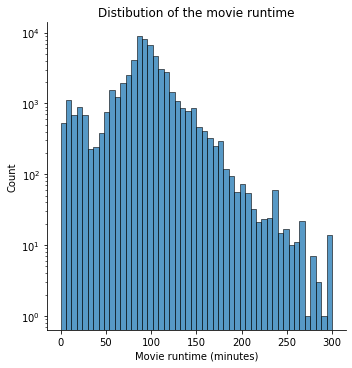

In [34]:
sns.displot(data=df_movie, x="Movie runtime", log_scale = (False, True), kind="hist", bins=50)
plt.title("Distibution of the movie runtime")
plt.xlabel("Movie runtime (minutes)")
plt.show()

In [35]:
#check how much NaNs we have for each feature of df_movie
100*np.mean(pd.isna(df_movie), axis=0)

Wikipedia movie ID              0.000000
Freebase movie ID               0.000000
Movie name                      0.000000
Movie release date              0.000000
Movie box office revenue       88.872112
Movie runtime                  21.821510
Movie languages                13.374043
Movie countries                 6.985663
Movie genres                    2.354387
Movie languages filtered        0.000000
Movie countries filtered        0.000000
Movie genres filtered           0.000000
Movie release date filtered     0.000000
startYear                       0.000000
dtype: float64

As we can observe, a lot of NaNs are situated in the Movie box office revenue. Thus, we can not use this feature for our study. As we want to assess the quality of a movie, we decided to add a Dataset, which contains movie raitings. More details below.  

In [36]:
100*np.mean(pd.isna(df_character), axis=0)

Wikipedia movie ID             0.000000
Freebase Movie ID              0.000000
Movie release date             2.217814
Character Name                57.220488
Actor DOB                     23.552763
Actor gender                  10.120288
Actor height                  65.645740
Actor ethnicity               76.466542
Actor Name                     0.272484
Actor age at movie release    35.084064
Freebase character map         0.180842
dtype: float64

Some features cannot be used, as Actor height, ethnicity and character name. 

In [37]:
def get_main_val(row, col):
    try:
        info = json.loads(row[col])
        return list(info.values())[0]
    except TypeError:
        pass

In [38]:
def get_count_val(row, col):
    try:
        info = json.loads(row[col])
        return len(info)
    except TypeError:
        pass

In [39]:
def get_main_genre(row):
    return get_main_val(row, "Movie genres")

In [40]:
def get_count_countries(row):
    return get_count_val(row, "Movie countries")

In [41]:
def get_main_country(row):
    return get_main_val(row, "Movie countries")

In [42]:
df_movie["Main genre"] = df_movie.apply(get_main_genre, axis=1)
df_movie["Main countries"]  = df_movie.apply(get_main_country, axis=1)
df_movie["Countries count"] = df_movie.apply(get_count_countries, axis=1)

In the next cells we will be focusing in the study of the date distribution. It is important for our study, because our whole project is a study as function of time. Looking at the minimum we see that we have an outlier at 1010.0. So we decided to drop it because television wasn't even invented at that time.

In [50]:
np.min(df_movie["Movie release date filtered"])

1010

In [49]:
np.sum(df_movie["Movie release date filtered"] < 1800)

1

In [52]:
df_movie.loc[df_movie["Movie release date filtered"] < 1800, ["Movie release date filtered"]] = np.nan

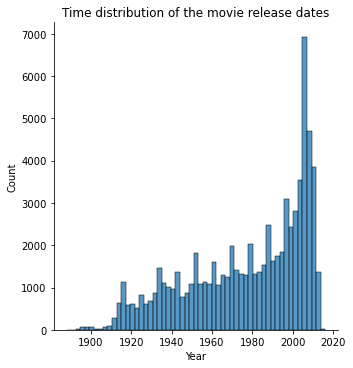

In [53]:
sns.displot(data=df_movie, x="Movie release date filtered", kind="hist")
plt.title("Time distribution of the movie release dates")
plt.xlabel("Year")
plt.show()

The number of movies are increasing. Thus, we will have an increase number of edges (which correspond to movies) in our graph, as a function of time.

In [54]:
countries = df_movie["Main countries"].groupby(df_movie["Main countries"]).agg(['count'])
countries = countries.reset_index()

In [55]:
countries = countries.sort_values('count', ascending=False)
list_countries = countries['Main countries'][0:10]
countries_plot = df_movie[df_movie["Main countries"].isin(list_countries)]
countries_plot

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered,Movie release date filtered,startYear,Main genre,Main countries,Countries count,
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,2001,Thriller,United States of America,1.0,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,2000,Mystery,United States of America,1.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0,1987,Thriller,United Kingdom,1.0,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...","Silent film, English Language",United States of America,"Short Film, Silent film, Indie, Black-and-whit...",1913.0,1913,Short Film,United States of America,1.0,NaN
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0,1938,Musical,United States of America,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81733,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",English Language,United Kingdom,"Crime Fiction, Thriller, Comedy, Supernatural",1941.0,1941,Crime Fiction,United Kingdom,1.0,NaN
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,United States of America,Drama,2011.0,2011,Drama,United States of America,1.0,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,United States of America,"Satire, Comedy",1972.0,1972,Satire,United States of America,1.0,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A...",1992.0,1992,Science Fiction,Japan,1.0,NaN


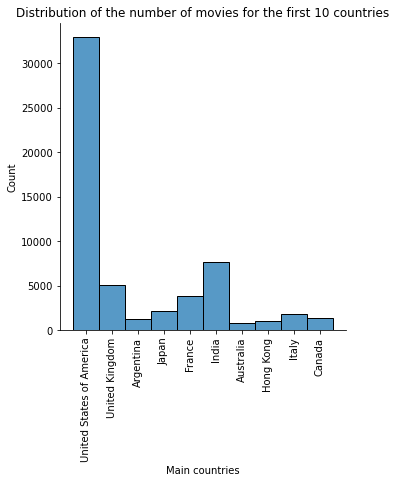

In [56]:
sns.displot(data=countries_plot, x="Main countries")
plt.xticks(rotation=90)
plt.title("Distribution of the number of movies for the first 10 countries")
plt.show()

## 6.Study of the Additional Dataset ##
In this stage we prepared a new dataframe by merging the two dataframes we imported from the IMDb database. The new dataframe we will obtain will have the average trating associated to the original title. Furthermore we changed some column names to facilitate future processing and merging.

In [57]:
df_IMDb_ex = df_movies_IMDb_name.merge(df_movies_IMDb_ratings, how ='inner', on=['tconst'])

In [58]:
df_IMDb_ex = df_IMDb_ex.rename(columns={"originalTitle": "Movie name"})
df_IMDb_ex

,tconst,titleType,primaryTitle,Movie name,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1922
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",5.8,259
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1735
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",5.6,174
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2548
...,...,...,...,...,...,...,...,...,...,...,...
1247714,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012,\N,10,"Adventure,Animation,Comedy",7.4,6
1247715,tt9916720,short,The Nun 2,The Nun 2,0,2019,\N,10,"Comedy,Horror,Mystery",5.3,276
1247716,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,\N,8.0,8
1247717,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Game-Show,Reality-TV",6.7,21


#### 6.1 Studying the complementarity of the additional and original datasets ####
In the next step we merge the two datasets to see how many movies from the original datasets have actually a rating in the additional dataset. We will then see how many actors from the original datasets have ratings.

In [62]:
df_exploitable = df_movie.merge(df_IMDb_ex, how ='inner', on=['Movie name', 'startYear'])

In [63]:
df_exploitable = df_exploitable.drop_duplicates(subset = "Wikipedia movie ID") 

In [64]:
df_exploitable

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,...,,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,NaN,tt0228333,movie,Ghosts of Mars,0,\N,98,"Action,Horror,Sci-Fi",4.9,55271
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norwegian Language,...,NaN,tt0094806,movie,Brun bitter,0,\N,83,"Crime,Drama",5.7,40
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...","Silent film, English Language",...,NaN,tt0002894,short,The Gangsters,0,\N,35,"Comedy,Short",6.8,16
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",English Language,...,NaN,tt0029852,movie,Alexander's Ragtime Band,0,\N,106,"Drama,Music,Musical",6.9,2160
5,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",English Language,...,NaN,tt0021335,movie,Sarah and Son,0,\N,86,"Drama,Romance",5.4,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46506,15394941,/m/03m6zh4,Gopi Kishan,1994-12-02,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/02kdv5l"": ""Action""...",Hindi Language,...,NaN,tt0109922,movie,Gopi Kishan,0,\N,161,"Action,Comedy,Drama",5.8,913
46507,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",English Language,...,NaN,tt0033660,movie,The Ghost Train,0,\N,85,"Comedy,Horror",6.2,1531
46508,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,...,NaN,tt1816585,tvMovie,Mermaids: The Body Found,0,\N,82,Sci-Fi,4.6,1656
46509,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",English Language,...,NaN,tt1606259,movie,Knuckle,0,\N,97,"Biography,Documentary,Drama",6.8,3081


#### 6.2 Obtaining our final Dataframe ####
In the next step we obtain our final dataframe, the one we will work with. To work we need four main feature and we will maybe add some more later but for the moment it will be: Movie name, Actor name, averageRating (the average rating), and finally the startYear.

In [66]:
df_exploitable_character = df_exploitable.merge(df_character, how ='inner', on=['Wikipedia movie ID'])
df_years_ascending = df_exploitable_character.sort_values(['startYear'], axis=0, ascending=True, inplace=False, kind='quicksort')

In [67]:
df_years_ascending

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,...,Freebase Movie ID,Movie release date_y,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map
212680,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Silent film,...,/m/044ggd,1888,NaN,NaN,F,NaN,NaN,Sarah Whitley,NaN,/m/0k2pz0
212679,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Silent film,...,/m/044ggd,1888,NaN,NaN,M,NaN,NaN,Adolphe Le Prince,NaN,/m/0k2pyv
212681,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Silent film,...,/m/044ggd,1888,NaN,NaN,M,NaN,NaN,Joseph Whitley,NaN,/m/0k2pz6
212682,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Silent film,...,/m/044ggd,1888,NaN,NaN,F,NaN,NaN,Harriet Hartley,NaN,/m/0k2pzd
96169,644824,/m/02_1qn,Dickson Greeting,1891,NaN,0.05,NaN,"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0219x_"": ""Indie""}",None,...,/m/02_1qn,1891,NaN,1860-08-03,M,NaN,/m/03lmx1,William Dickson,NaN,/m/081ks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201924,36127934,/m/0k0tq97,Maleficent,2014-03-14,NaN,NaN,NaN,NaN,"{""/m/01hmnh"": ""Fantasy""}",None,...,/m/0k0tq97,2014-03-14,NaN,1975-06-04,F,1.73,/m/027n1m6,Angelina Jolie,38.0,/m/0f4vbz
201926,36127934,/m/0k0tq97,Maleficent,2014-03-14,NaN,NaN,NaN,NaN,"{""/m/01hmnh"": ""Fantasy""}",None,...,/m/0k0tq97,2014-03-14,NaN,1956-01-09,F,1.52,/m/02w7gg,Imelda Staunton,58.0,/m/01tspc6
201927,36127934,/m/0k0tq97,Maleficent,2014-03-14,NaN,NaN,NaN,NaN,"{""/m/01hmnh"": ""Fantasy""}",None,...,/m/0k0tq97,2014-03-14,NaN,1958-03-03,F,1.65,/m/02w7gg,Miranda Richardson,56.0,/m/0525b
128957,36534974,/m/0kdy118,Noah,2014-03-28,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01hmnh"": ""Fantasy""}",English Language,...,/m/0kdy118,2014-03-28,Ila,1990-04-15,F,1.68,/m/0d7wh,Emma Watson,23.0,/m/0134w7


In [68]:
df_exploitable_character

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,...,Freebase Movie ID,Movie release date_y,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,...,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300180,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",English Language,...,/m/06_vb43,1941-05-03,NaN,1900-01-14,M,NaN,NaN,Wilfrid Lawson,41.0,/m/025w40r
300181,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",English Language,...,/m/06_vb43,1941-05-03,NaN,1891-08-08,M,NaN,NaN,Morland Graham,NaN,/m/0gc08qy
300182,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",English Language,...,/m/06_vb43,1941-05-03,NaN,1869,M,NaN,NaN,D.J. Williams,NaN,/m/0gcwx9k
300183,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,...,/m/02pygw1,1972-09-22,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/03m6t5


In [69]:
df_final = df_exploitable_character[['Actor Name','Movie name','startYear','averageRating']]
df_final

,Actor Name,Movie name,startYear,averageRating
0,Wanda De Jesus,Ghosts of Mars,2001,4.9
1,Natasha Henstridge,Ghosts of Mars,2001,4.9
2,Ice Cube,Ghosts of Mars,2001,4.9
3,Jason Statham,Ghosts of Mars,2001,4.9
4,Clea DuVall,Ghosts of Mars,2001,4.9
...,...,...,...,...
300180,Wilfrid Lawson,The Ghost Train,1941,6.2
300181,Morland Graham,The Ghost Train,1941,6.2
300182,D.J. Williams,The Ghost Train,1941,6.2
300183,Rich Little,Another Nice Mess,1972,5.8


In [70]:
df_final_visualization = df_final['Actor Name'].groupby(df_final['Actor Name']).agg(['count'])
df_final_visualization[df_final_visualization['count']>10]
#df_final_visualization

,count
Actor Name,
50 Cent,19
A.K Hangal,31
Aahuthi Prasad,17
Aamir Khan,25
Aaron Eckhart,23
...,...
Zohra Sehgal,21
Zooey Deschanel,25
Zoë Kravitz,11


## Bonus ##
In the next cells we tried looking at an other dataset to evaluate its potential but sadly there wasn't enough data for us to use it. We also looked on the ratings and discovered that there we also coming from the IMDb database so it was just redundant.

In [71]:
df_movies_kaggle.drop(df_movies_kaggle[df_movies_kaggle['vote_average'] == 0.0].index, inplace = True)
df_movies_kaggle = df_movies_kaggle.rename(columns={"original_title": "Movie name", "imdb_id": "tconst"})
df_movies_test = df_movies_kaggle.merge(df_IMDb_ex, how ='inner', on=['Movie name', 'tconst'])

In [72]:
df_movies_test

,adult,belongs_to_collection,budget,genres_x,homepage,id,tconst,original_language,Movie name,overview,...,vote_count,titleType,primaryTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,5415.0,movie,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989276
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,2413.0,movie,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",7.0,346227
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,92.0,movie,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",6.6,27936
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,34.0,movie,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",5.9,11148
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,173.0,movie,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",6.0,38844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34704,False,NaN,0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",NaN,390959,tt0265736,en,Shadow of the Blair Witch,"In this true-crime documentary, we delve into ...",...,2.0,tvMovie,Shadow of the Blair Witch,0,2000,\N,45,"Horror,Mystery",5.2,487
34705,False,NaN,0,"[{'id': 27, 'name': 'Horror'}]",NaN,289923,tt0252966,en,The Burkittsville 7,A film archivist revisits the story of Rustin ...,...,1.0,tvMovie,The Burkittsville 7,0,2000,\N,30,Horror,6.4,265
34706,False,NaN,0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,222848,tt0112613,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,...,1.0,movie,Caged Heat 3000,0,1995,\N,80,"Action,Sci-Fi",3.6,387
34707,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",...,26.0,movie,Robin Hood,0,1991,\N,104,"Action,Adventure,Drama",5.7,5312


In [73]:
df_movies_test_prime = df_movies_test.merge(df_movie, how ='inner', on=['Movie name'])

In [74]:
df_movies_test_prime

,adult,belongs_to_collection,budget,genres_x,homepage,id,tconst,original_language,Movie name,overview,...,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered,Movie release date filtered,startYear_y,Main genre,Main countries,Countries count,
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"{""/m/0556j8"": ""Buddy film"", ""/m/03k9fj"": ""Adve...",English Language,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995.0,1995,Buddy film,United States of America,1.0,NaN
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"{""/m/01jfsb"": ""Thriller"", ""/m/0hj3n2k"": ""Fanta...","French Language, English Language","United States of America, Japan","Thriller, Fantasy Adventure, Japanese Movies, ...",1995.0,1995,Thriller,United States of America,2.0,NaN
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0556j8"": ""...","Italian Language, English Language",United States of America,"Romantic comedy, Buddy film, Comedy",1995.0,1995,Romantic comedy,United States of America,1.0,NaN
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/06w2n3t"": ...",English Language,United States of America,"Ensemble Film, Female buddy film, Comedy-drama...",1995.0,1995,Ensemble Film,United States of America,1.0,NaN
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"{""/m/06qm3"": ""Screwball comedy"", ""/m/02l7c8"": ...",English Language,United States of America,"Screwball comedy, Romance Film, Family Film, C...",1995.0,1995,Screwball comedy,United States of America,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26564,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",NaN,84710,tt0036975,en,Jungle Woman,Paula the ape woman (Acquanetta) is alive and ...,...,"{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",English Language,United States of America,"Science Fiction, Horror, Sci-Fi Horror, Jungle...",1944.0,1944,Science Fiction,United States of America,1.0,NaN
26565,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",NaN,39562,tt0889600,en,To Be Fat Like Me,"Pretty, popular, and slim high-schooler Aly Sc...",...,"{""/m/07s9rl0"": ""Drama"", ""/m/015w9s"": ""Televisi...",English Language,"United States of America, Canada","Drama, Television movie",2007.0,2007,Drama,United States of America,2.0,NaN
26566,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,14008,tt0294425,en,Cadet Kelly,Hyperactive teenager Kelly is enrolled into a ...,...,"{""/m/0hqxf"": ""Family Film"", ""/m/0bj8m2"": ""Chil...",English Language,"United States of America, Canada","Family Film, Children's, Coming of age, Comedy...",2002.0,2002,Family Film,United States of America,2.0,NaN
26567,False,NaN,0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",NaN,14885,tt0457437,en,Pooh's Heffalump Halloween Movie,"It's Halloween in the 100 Acre Wood, and Roo's...",...,"{""/m/0hqxf"": ""Family Film"", ""/m/0hj3myq"": ""Chi...",English Language,United States of America,"Family Film, Children's/Family, Children's Fan...",2005.0,2005,Family Film,United States of America,1.0,NaN


In [75]:
df_tot = df_exploitable.merge(df_movies_test_prime, how ='outer', on=['Movie name'])
df_tot = df_tot.drop_duplicates(subset = "Movie name") 